# Building a NN using tf.keras and training it on the MNIST dataset.

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os

## Loading dataset

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train_full.shape

(60000, 28, 28)

In [4]:
x_test.shape

(10000, 28, 28)

- We have 60000 images of size 28*28 in the training dataset with each pixel having intensity ranging from 0 to 255.
- We have 10000 images in the test dataset having the same specs as above.

- We will be seperating the train set into train and validation set.

In [5]:
x_valid, x_train = x_train_full[:5000] / 255, x_train_full[5000:] / 255
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
x_test = x_test / 255

- Plotting an image in the dataset using imshow from matplotlib

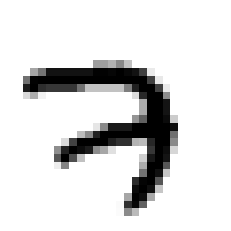

In [6]:
plt.imshow(x_train[0], cmap = 'binary')
plt.axis('off')
plt.show()

In [7]:
y_train[0]

7

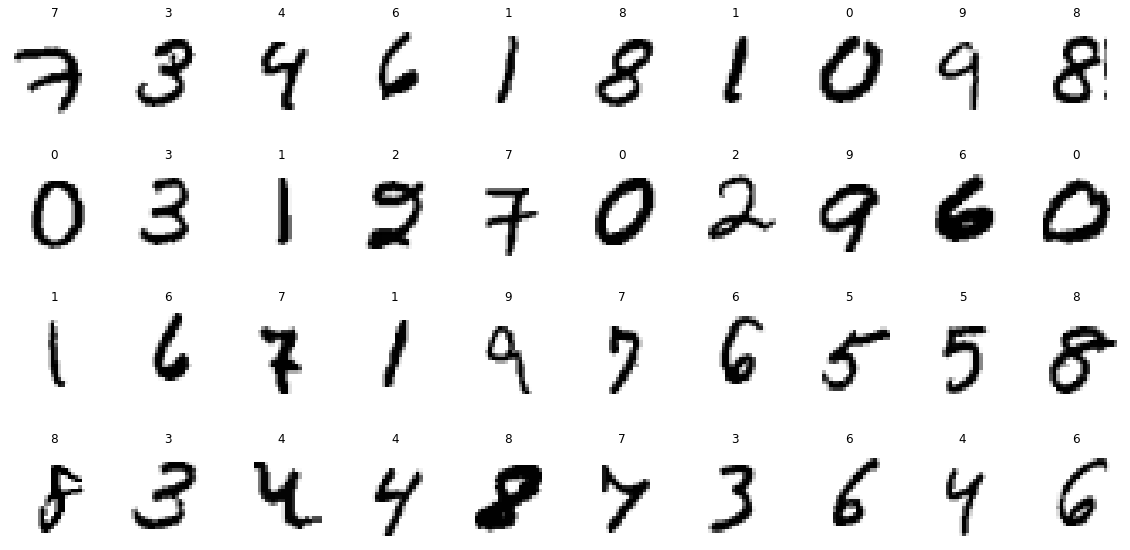

In [8]:
plt.figure(figsize = (20,10))
for row in range(4):
    for col in range(10):
        index = 10 * row + col
        plt.subplot(4, 10, index + 1)
        plt.imshow(x_train[index], cmap = 'binary')
        plt.axis('off')
        plt.title(y_train[index])
plt.show()

## Finding optimal learning rate

- Lets build a simple dense network and find the optimal learning rate.

In [9]:
k = keras.backend

In [10]:
class expon_learn_rate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.loss = []
    def on_batch_end(self, batch, logs):
        self.loss.append(logs['loss'])
        self.rates.append(k.get_value(self.model.optimizer.lr))
        k.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [11]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28,28]))
model.add(keras.layers.Dense(300, activation = 'relu'))
model.add(keras.layers.Dense(100, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.SGD(lr = 1e-3), metrics = ['accuracy'])

- We have used the sparse categorical crossentropy loss function as it is a classification task and an SGD optimizer with the initial learning rate set as 10^-3.
- Lets increase the lr by a factor of 0.5% at the end of eatch batch.

In [14]:
lr_increase = expon_learn_rate(factor = 1.005)

- We will be needing a callback to increase the learning raet at the end of each batch.

In [15]:
history = model.fit(x_train, y_train, epochs = 1, validation_data = (x_valid, y_valid), callbacks = [lr_increase])

1719/1719 [==============================] - 3s 2ms/step - loss: nan - accuracy: 0.5992 - val_loss: nan - val_accuracy: 0.0958


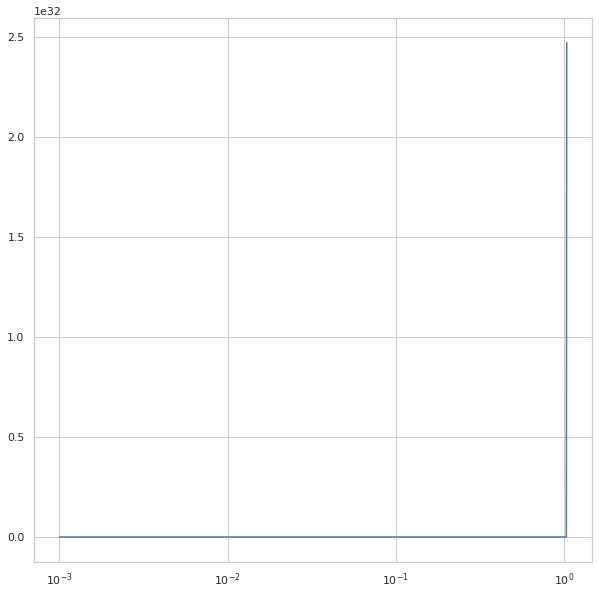

In [16]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (10, 10))
sns.lineplot(x = lr_increase.rates, y = lr_increase.loss)
plt.gca().set_xscale('log')

In [17]:
lr_increase.rates[lr_increase.loss.index(min(lr_increase.loss))]

0.9279009

- For lr = 0.985, the loss is at its minimum, therefore 0.98 can be taken as the optimal learning rate.

## Building the model

In [18]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28,28]))
model.add(keras.layers.Dense(300, activation = 'relu'))
model.add(keras.layers.Dense(100, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

- We have used the same architecture used for finding the optimal learning rate.

## Compiling the model

In [20]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.SGD(lr = 2e-1), metrics = ['accuracy'])

## Setting directory for logs

- We will be visualizing the learning curves on Tensorboard in the future, so we have to save the logs.

In [21]:
run_index = 2
run_log_dir = os.path.join(os.curdir, 'MNIST_logs', 'run_{}'.format(run_index))
run_log_dir

'./MNIST_logs/run_2'

## Callback initialization

In [22]:
early_stopping = keras.callbacks.EarlyStopping(patience = 20)
chechpoint_cb = keras.callbacks.ModelCheckpoint('MNIST_model_cp.h5', save_best_only = True)
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)

## Training the model

In [23]:
history = model.fit(x_train, y_train, epochs = 100, validation_data = (x_valid, y_valid), callbacks = [early_stopping, chechpoint_cb, tensorboard_cb])

Epoch 1/100
   1/1719 [..............................] - ETA: 0s - loss: 2.5649 - accuracy: 0.0625WARNING:tensorflow:From /home/gokul/.local/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2377 - accuracy: 0.9270 - val_loss: 0.1021 - val_accuracy: 0.9696
Epoch 2/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0941 - accuracy: 0.9710 - val_loss: 0.0868 - val_accuracy: 0.9754
Epoch 3/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0641 - accuracy: 0.9802 - val_loss: 0.0779 - val_accuracy: 0.9772
Epoch 4/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0464 - accuracy: 0.9841 - val_loss: 0.0749 - val_accuracy: 0.9800
Epoch 5/100
1719/1719 [=========================

## Rollback to best model

In [24]:
#model = keras.models.load_model('MNIST_model_cp.h5')

In [25]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 936us/step - loss: 0.0792 - accuracy: 0.9833


[0.07919970899820328, 0.983299970626831]

- We obtained an accuracy 